In [1]:
from exp.expdata import LotkaVolterraExp
import matplotlib.pyplot as plt

In [2]:
noise=0.5
noise = 0.0
dt_train = 5.1
expdata = LotkaVolterraExp(t0=0.,t1=50.,noise=noise, dt_train=dt_train,n_colloc=500, feature_names=['x','y'])

In [3]:
x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train

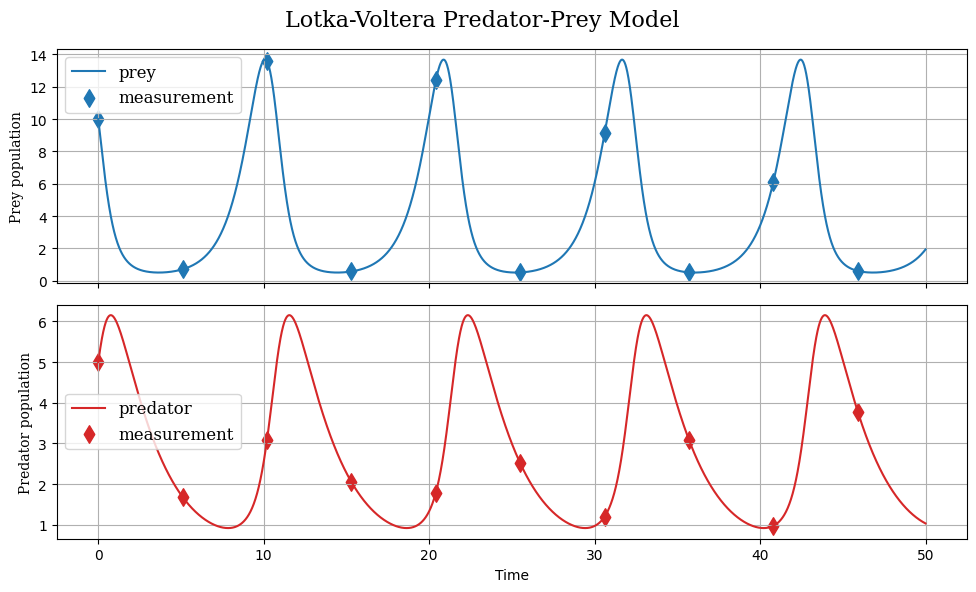

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="prey", c='tab:blue',)
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80)
ax1.set_ylabel("Prey population", fontname=fontname)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='tab:red', marker='d',s=80)
ax2.set_ylabel("Predator population", fontname=fontname)
ax2.set_xlabel("Time")
ax2.grid(True)
ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

$$\dot x = \alpha x - \beta x y$$
$$\dot y = -\gamma y + \delta x y $$

where $\alpha = 1.1$, $\beta = 0.4$, $\gamma  = 0.4$, and $\delta = 0.1$.

In [5]:
expdata.print(precision=1)

(x)' = 1.1 x + -0.4 x y
(y)' = -0.4 y + 0.1 x y


Estimated dominant frequency: 0.100 Hz
Nyquist sampling frequency: 0.200 Hz
Sampling rate: 5.000 s


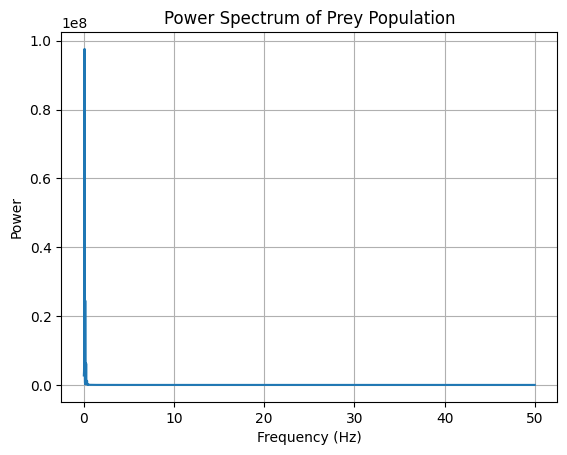

In [6]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# Assuming `sol` from earlier
prey = x_true[:,0]
t = t_true
dt = t[1] - t[0]

# Perform FFT
Y = fft(prey - np.mean(prey))  # Remove DC component
freqs = fftfreq(len(t), dt)

# Only positive frequencies
pos_mask = freqs > 0
pos_freqs = freqs[pos_mask]
power = np.abs(Y[pos_mask])**2

# Find peak frequency
f_max = pos_freqs[np.argmax(power)]
nyquist_fs = 2 * f_max

print(f"Estimated dominant frequency: {f_max:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs:.3f} s")

# Optional: Plot spectrum
plt.plot(pos_freqs, power)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of Prey Population")
plt.grid(True)
plt.show()


# Learn Model

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ


In [8]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight =  50.
colloc_weight = 100.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [9]:
from exp.evaluate.jsindy import evaluate_jmodel

In [10]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(2.58236624, dtype=float64), 'data_weight': 50.0, 'colloc_weight': 100.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 1.876e+05, gradnorm = 1.884e+05, alpha = 45.56, improvement_ratio = 0.1604
Iteration 1, loss = 1.541e+04, gradnorm = 4.115e+06, alpha = 37.97, improvement_ratio = 0.919
Iteration 2, loss = 1.443e+04, gradnorm = 2.883e+05, alpha = 45.56, improvement_ratio = 0.06493
Iteration 3, loss = 1.092e+03, gradnorm = 4.228e+05, alpha = 37.97, improvement_ratio = 0.9363
Iteration 4, loss = 246.7, gradnorm = 9.582e+04, alpha = 31.64, improvement_ratio = 0.8608
Iteration 5, loss = 193.2, gradnorm = 4.35e+04, alpha = 71.19, improvement_ratio = 0.3078
Line Search Failed!
Final Iteration Results
Iteration 183, loss = 0.04563, gradnorm = 1.682e-07, alpha = 279.9, improvement_ratio = -317.0
Model after smooth warm start
(x)' = 0.001 1 + 1.100 x + -0.400 x y
(y)' = 0.006 1 + -0.001 x + -0.404 y + 0.100 x y + 0.001 y^2
Alternating Activeset Sparsifier
6 active coeffs changed
Active set stabilized
(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


{'mse': Array(6.69832066e-08, dtype=float64),
 'rmse': np.float64(0.00025881114086679464),
 'mae': np.float64(0.00013403936096165395),
 'max_abs_error': np.float64(0.0010265867724346123),
 'normalized_mse': Array(9.94528942e-09, dtype=float64),
 'relative_l2_error': np.float64(9.961863192729034e-05)}

In [11]:
expdata.print()

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


In [13]:
pred_sim = model.predict_state(expdata.t_true)
true = expdata.x_true

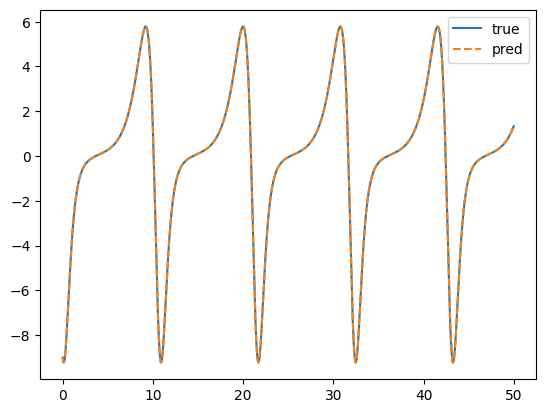

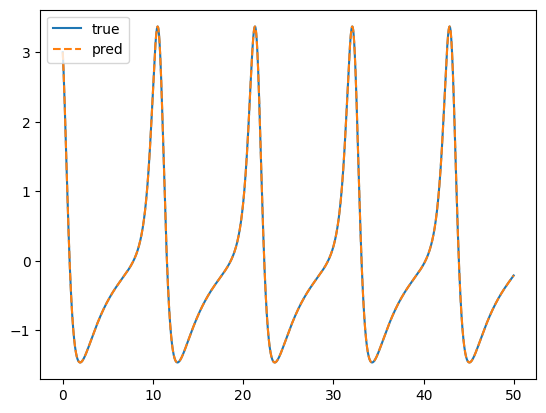

In [22]:
for i in range(len(pred_sim.T)):
    plt.plot(t_true, true[:,i], label='true')
    plt.plot(t_true, pred_sim[:,i], label='pred', linestyle='--')
    plt.legend()
    plt.show()

In [19]:
pred_sim = model.predict(expdata.x_true)
true = expdata.x_dot

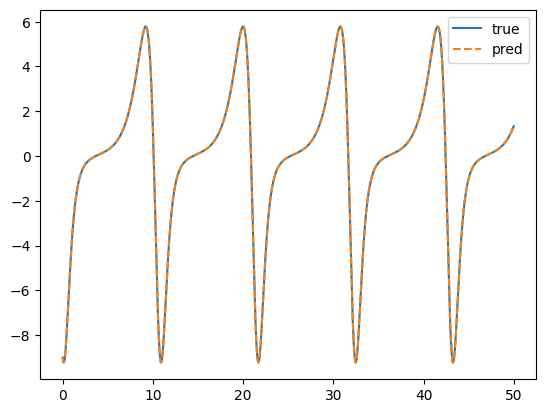

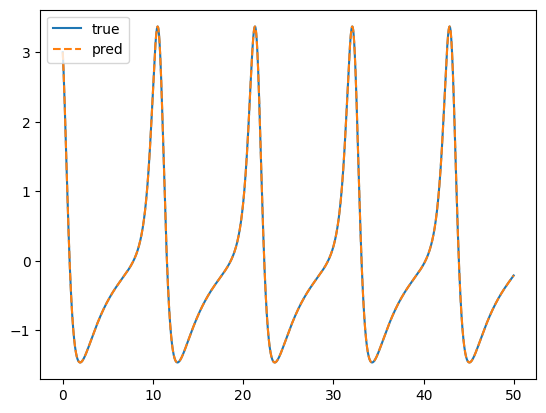

In [21]:
for i in range(len(pred_sim.T)):
    plt.plot(t_true, true[:,i], label='true')
    plt.plot(t_true, pred_sim[:,i], label='pred', linestyle='--')
    plt.legend()
    plt.show()